Heurística para escolher o melhor valor de cada característica: Tarefa 5 da disciplina Reconhecimento de Padrões. 

Professor: Francisco de Assis Boldt 

Aluno: Diogo de Santana Candido

In [244]:
# Versão da Linguagem Python
from platform import python_version
print('Versão da Linguagem Python Usada Neste Jupyter Notebook:', python_version())

Versão da Linguagem Python Usada Neste Jupyter Notebook: 3.8.10


Carga do dataset com atributos contínuos.

In [245]:
from sklearn.datasets import load_iris
iris = load_iris()
X, y = iris.data[:,2:], iris.target

Tarefa - Crie a sua heurística para escolher a melhor característica para um nó de uma árvore de decisão e compare com a implementação feita nos vídeos postados nesse tópico aqui no AVA e com a implementação do scikit learn.

Cálculo das impurezas

In [246]:
import numpy as np
import math

# Impureza de Gini

def impureza(y): 
    labels = list(set(y))
    labels.sort()
    probabilidades = np.zeros((len(labels),))
    for i,k in enumerate(labels):
        probabilidades[i] = sum(y==k)/len(y)
    result = 1 - sum(probabilidades**2)
    return result

# Cálculo dos valores das impurezas utilizando atributos continuos 

def impurezaValor(x, y, valor):
    maiores = x > valor
    impurezaMaiores = impureza(y[maiores])
    propMaiores = sum(maiores)/len(y)
    impurezaMenores = impureza(y[~maiores])
    propMenores = sum(~maiores)/len(y)
    impurezaTotal = impurezaMaiores*propMaiores + impurezaMenores*propMenores
    return impurezaTotal, impurezaMaiores, impurezaMenores

Cálculo da heurística 1 cujo o valor é a média geométrica entre o maior e o menor valor.

In [247]:
# Heurística 1 utilizando média geométrica

def melhorValor1(x, y):
   result = None
   menorImpureza = float('inf')
   xmax = np.max(x)
   xmin = np.min(x)
   while True:
        valor = math.sqrt(xmin*xmax) # média geométrica
        impTotal, impMaiores, impMenores =  impurezaValor(x, y, valor)
        if impTotal < menorImpureza:
            menorImpureza = impTotal
            result = valor
            if impMaiores == 0 or impMenores == 0:
                break
            if impMaiores < impMenores:
                xmin = valor
            else:
                xmax = valor
        else:
            break
   return result, menorImpureza

melhorValor1(X[:,0], y)

(2.6267851073127395, 0.3333333333333333)

Cálculo da heurística 2 cujo o valor é a média aritmética entre o maior e o menor valor (conforme os vídeos da disciplina).

In [248]:
# Heurística 2 utilizando média aritimética (vídeo)

def melhorValor2(x, y):
   result = None
   menorImpureza = float('inf')
   xmax = np.max(x)
   xmin = np.min(x)
   while True:
        valor = (xmin+xmax)/2 # média aritmética
        impTotal, impMaiores, impMenores =  impurezaValor(x, y, valor)
        if impTotal < menorImpureza:
            menorImpureza = impTotal
            result = valor
            if impMaiores == 0 or impMenores == 0:
                break
            if impMaiores < impMenores:
                xmin = valor
            else:
                xmax = valor
        else:
            break
   return result, menorImpureza

melhorValor2(X[:,0], y)

(2.475, 0.3333333333333333)

Cálculo da melhor característica utilizando a heurística 1.

In [249]:

def melhorCaracteristica1(X, y):
    impurezas = []
    valores =  []
    for caracteristica in range(X.shape[1]):
      valor, imp = melhorValor1(X[:, caracteristica], y)
      impurezas.append(imp) 
      valores.append(valor)
    impurezas = np.array(impurezas)
    caracteristica = np.argmin(impurezas)
    return caracteristica, valores[caracteristica], impurezas[caracteristica]

melhorCaracteristica1(X, y)

(0, 2.6267851073127395, 0.3333333333333333)

Cálculo da melhor característica utilizando a heurística 2 (conforme os vídeos da disciplina).

In [250]:

def melhorCaracteristica2(X, y):
    impurezas = []
    valores =  []
    for caracteristica in range(X.shape[1]):
      valor, imp = melhorValor2(X[:, caracteristica], y)
      impurezas.append(imp) 
      valores.append(valor)
    impurezas = np.array(impurezas)
    caracteristica = np.argmin(impurezas)
    return caracteristica, valores[caracteristica], impurezas[caracteristica]

melhorCaracteristica2(X, y)

(0, 2.475, 0.3333333333333333)

Implementação da árvore de decisão utilizando a heurística 1.

In [251]:
from sklearn.metrics import accuracy_score
import numpy as np
from collections import Counter
from sklearn.base import BaseEstimator, ClassifierMixin

def maisFrequente(y):
    return Counter(y.flat).most_common(1)[0][0]

class Arvore1(BaseEstimator, ClassifierMixin):
    def fit(self, X, y):
        self.caracteristica, self.valor, self.imp = melhorCaracteristica1(X, y)
        maiores = X[:,self.caracteristica] > self.valor
        if sum(maiores)>0 and sum(~maiores)>0:
            self.maiores = Arvore1()
            self.maiores.fit(X[maiores,:],y[maiores])
            self.menores = Arvore1()
            self.menores.fit(X[~maiores,:],y[~maiores])
        else:
            self.resposta = maisFrequente(y)
    def predict(self, X):
        y = np.empty((X.shape[0]))
        if hasattr(self, 'resposta'):
            y[:] = self.resposta
        else:
            maiores = X[:,self.caracteristica] > self.valor
            y[maiores] = self.maiores.predict(X[maiores,:])
            y[~maiores] = self.menores.predict(X[~maiores,:])
        return y



Implementação da árvore de decisão utilizando a heurística 2 (conforme os vídeos da disciplina).

In [252]:
class Arvore2(BaseEstimator, ClassifierMixin):
    def fit(self, X, y):
        self.caracteristica, self.valor, self.imp = melhorCaracteristica2(X, y)
        maiores = X[:,self.caracteristica] > self.valor
        if sum(maiores)>0 and sum(~maiores)>0:
            self.maiores = Arvore2()
            self.maiores.fit(X[maiores,:],y[maiores])
            self.menores = Arvore2()
            self.menores.fit(X[~maiores,:],y[~maiores])
        else:
            self.resposta = maisFrequente(y)
    def predict(self, X):
        y = np.empty((X.shape[0]))
        if hasattr(self, 'resposta'):
            y[:] = self.resposta
        else:
            maiores = X[:,self.caracteristica] > self.valor
            y[maiores] = self.maiores.predict(X[maiores,:])
            y[~maiores] = self.menores.predict(X[~maiores,:])
        return y


Avaliação dos algoritmos de classificação

In [253]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression


for Algoritmo in [Arvore1, Arvore2, DecisionTreeClassifier, KNeighborsClassifier, LogisticRegression]:
    modelo = Algoritmo()
    modelo.fit(X,y)
    ypred = modelo.predict(X)
    print("Modelo: ", modelo, "Acurácia: ", accuracy_score(y, ypred))

Modelo:  Arvore1() Acurácia:  0.9933333333333333
Modelo:  Arvore2() Acurácia:  0.9933333333333333
Modelo:  DecisionTreeClassifier() Acurácia:  0.9933333333333333
Modelo:  KNeighborsClassifier() Acurácia:  0.96
Modelo:  LogisticRegression() Acurácia:  0.9666666666666667


Tarefa: Faça comparações plotando as regiões de decisão com resubstituição para a base iris e as características usadas nos vídeos.

In [254]:
import matplotlib.pyplot as plt

def plotDecisao(modelo, X, y):
    modelo.fit(X, y)
    x0s = np.linspace(np.min(X[:,0])-0.2, np.max(X[:,0])+0.2, 100)
    x1s = np.linspace(np.min(X[:,1])-0.2, np.max(X[:,1])+0.2, 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    Xdec = np.c_[x0.ravel(), x1.ravel()]
    ypred = modelo.predict(Xdec)
    plt.contourf(x0, x1, ypred.reshape(x0.shape), alpha=0.25)
    for k in set(y):
        plt.plot(X[:,0][y==k], X[:,1][y==k], 'o', label=f"{iris.target_names[k]} [{k}]")

    plt.xlabel(f"X[0]: {iris.feature_names[0]}")
    plt.ylabel(f"X[1]: {iris.feature_names[1]}")
    plt.show()

Modelo:  Arvore1()


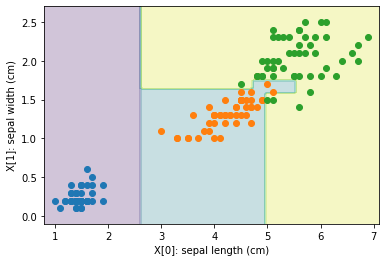

Modelo:  Arvore2()


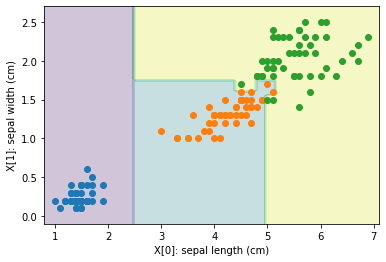

Modelo:  DecisionTreeClassifier()


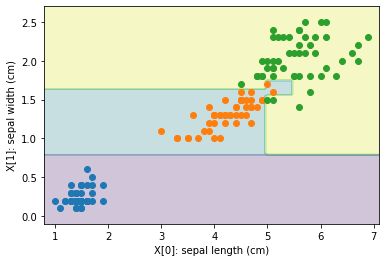

Modelo:  KNeighborsClassifier()


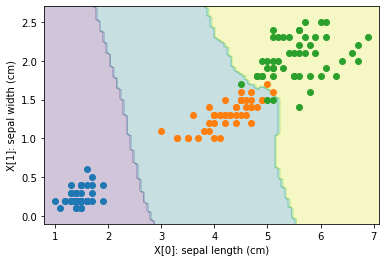

Modelo:  LogisticRegression()


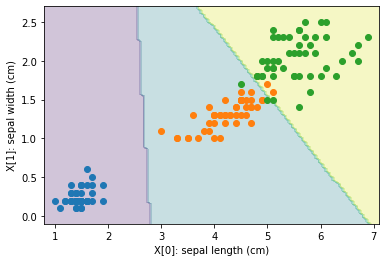

In [255]:
for Algoritmo in [Arvore1, Arvore2, DecisionTreeClassifier, KNeighborsClassifier, LogisticRegression]:
    modelo = Algoritmo()
    print("Modelo: ", modelo)
    plotDecisao(modelo, X, y)

Tarefa: Também faça comparações usando validação cruzada com pelo menos 3 bases de classificação com atributos contínuos. Escreva um parágrafo expondo sua interpretação dos resultados obtidos.

O primeiro conjunto de dados escolhido é o censo de 1994 que possui seus metadados em: https://archive.ics.uci.edu/ml/datasets/Adult

A tarefa de previsão é determinar se uma pessoa ganha mais de 50 mil dolares por ano (rótulo discreto). Para essa classificação são utilizados as características idade e horas por semana de trabalho da pessoa (atributo contínuos).

In [321]:
from sklearn.model_selection import cross_validate
from sklearn import preprocessing


data = np.loadtxt('/mnt/d/projetos/mestrado_ifes/reconhecimento_padroes/dataset/adult.data', dtype='str', delimiter=',')
X, y = data[:,0::12], data[:,-1]
X = X.astype(float)
y = preprocessing.LabelEncoder().fit_transform(y)

for Algoritmo in [Arvore1, Arvore2, DecisionTreeClassifier, KNeighborsClassifier, LogisticRegression]:
    modelo = Algoritmo()
    print("Modelo: ", modelo)
    scores = cross_validate(modelo, X, y)
    print(scores['test_score'], np.mean(scores['test_score']))




Modelo:  Arvore1()
[0.75387686 0.75737101 0.76243857 0.75967445 0.75752457] 0.7581770922339783
Modelo:  Arvore2()
[0.75387686 0.75691032 0.76259214 0.7602887  0.75844595] 0.7584227924796788
Modelo:  DecisionTreeClassifier()
[0.75664057 0.75706388 0.7664312  0.76197789 0.7590602 ] 0.7602347469113936
Modelo:  KNeighborsClassifier()
[0.71702748 0.73387592 0.72850123 0.72542998 0.73449017] 0.7278649561583693
Modelo:  LogisticRegression()
[0.75172731 0.75015356 0.75568182 0.75660319 0.75706388] 0.7542459543208047


Interpretação do resultado:  Observa-se com o resultado dos modelos (test_score) ficou próximo de 75% de acerto, isso demonstra que através das características idade e quantidade de horas de trabalho semanal consegue construir um modelo que acerte 75% da previsão da pessoa que ganha mais de 50 mil dolares por ano. 

O segundo conjunto de dados escolhido é o Fraude de Cartão de Crédito que possui seus metadados em: https://www.kaggle.com/datasets/dhanushnarayananr/credit-card-fraud

A tarefa de previsão é determinar se uma transação é fraudulenta (rótulo discreto). Para essa classificação são utilizados as características distância_de_casa (a distância de casa onde a transação ocorreu)  e distância_da_última_transação (a distância da última transação aconteceu) (atributo contínuos).

Obs.: Limitamos as 10.000 primeiras transações do conjunto de dados para a tarefa de classificação com o objetivo de o tempo de processamento ser razoável.

In [269]:
data = np.loadtxt('/mnt/d/projetos/mestrado_ifes/reconhecimento_padroes/dataset/card_transdata.csv', dtype='str', delimiter=',')

X, y = data[1:10000,:2], data[1:10000,-1]
X = X.astype(float)
y = preprocessing.LabelEncoder().fit_transform(y)

for Algoritmo in [Arvore1, Arvore2, DecisionTreeClassifier, KNeighborsClassifier, LogisticRegression]:
    modelo = Algoritmo()
    print("Modelo: ", modelo)
    scores = cross_validate(modelo, X, y)
    print(scores['test_score'], np.mean(scores['test_score']))


Modelo:  Arvore1()
[0.8575     0.8535     0.853      0.843      0.85442721] 0.8522854427213608
Modelo:  Arvore2()
[0.8545     0.8465     0.8435     0.843      0.84092046] 0.845684092046023
Modelo:  DecisionTreeClassifier()
[0.868      0.8575     0.856      0.856      0.85742871] 0.8589857428714357
Modelo:  KNeighborsClassifier()
[0.922      0.9135     0.912      0.915      0.91095548] 0.914691095547774
Modelo:  LogisticRegression()
[0.918      0.9165     0.9155     0.915      0.91595798] 0.9161915957978989


Interpretação do resultado: Observa-se com o resultado dos modelos (test_scores) que utilizando o algoritmo de árvore de decisão a classificação teve a precisão de 85% de acerto e com outros algoritmos de classificação a precisão de acerto subiu para 91% de acerto. Isso demonstra que através das características distância de casa e distância da última transação consegue construir um modelo de árvore de decisão que acerte 85% da previsão se a operação é fraudulenta e um outro modelo de classificação que acerte 91% da previsão se a operação é fraudulenta. Essa diferença pode ser devido as características selecionadas se adaptarem melhor a outros modelos de classificação do que o de árvore de decisão.

 O terceiro conjunto de dados escolhido é a previsão de ataque cardíaco que possui seus metadados em: https://www.kaggle.com/datasets/rashikrahmanpritom/heart-attack-analysis-prediction-dataset

A tarefa de previsão é determinar se uma pessoa tem mais chances de sofre um ataque cardíaco (rótulo discreto). Para essa classificação são utilizados as características age:"idade do paciente", trtbps: "pressão arterial em repouso (em mm Hg)", chol: "colestoral em mg/dl obtido através do sensor de IMC" e thalach:"frequência cardíaca máxima atingida" (atributos contínuos).

In [334]:
data = np.loadtxt('/mnt/d/projetos/mestrado_ifes/reconhecimento_padroes/dataset/heart.csv', dtype='str', delimiter=',')
X, y = data[1:,[0, 3, 4, 7] ], data[1:,-1]
X = X.astype(float)
y = y.astype(int)

for Algoritmo in [Arvore1, Arvore2, DecisionTreeClassifier, KNeighborsClassifier, LogisticRegression]:
    modelo = Algoritmo()
    print("Modelo: ", modelo)
    scores = cross_validate(modelo, X, y)
    print(scores['test_score'], np.mean(scores['test_score']))



Modelo:  Arvore1()
[0.62295082 0.63934426 0.57377049 0.63333333 0.58333333] 0.6105464480874316
Modelo:  Arvore2()
[0.59016393 0.55737705 0.47540984 0.63333333 0.75      ] 0.6012568306010928
Modelo:  DecisionTreeClassifier()
[0.60655738 0.67213115 0.47540984 0.6        0.61666667] 0.5941530054644809
Modelo:  KNeighborsClassifier()
[0.60655738 0.6557377  0.57377049 0.75       0.65      ] 0.6472131147540983
Modelo:  LogisticRegression()
[0.63934426 0.6557377  0.73770492 0.76666667 0.7       ] 0.6998907103825136


Interpretação do resultado:  Observa-se com o resultado dos modelos (test_score) que utilizando o algoritmo de árvore de decisão a classificação teve a precisão próxima de 60% de acerto e para o modelos KNeighborsClassifier() e LogisticRegression() a precisão de acerto foi de 64,7% e de 69,9%, respectivamente. Isso demonstra que o modelo de regressão logística obtém o melhor 
resultado para prever se um paciente tem mais chances de sofrer um ataque cardíaco utilizando as características age:"idade do paciente", trtbps: "pressão arterial em repouso (em mm Hg)", chol: "colestoral em mg/dl obtido através do sensor de IMC" e thalach:"frequência cardíaca máxima atingida".

 